- Messages
- Chat Models
- Tools
- State
- Graph
- Router
- Agents
- Agents with Memory

In [ ]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated
from langchain_core.messages import AnyMessage
from IPython.display import Image, display

from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver



In [ ]:
# --- Messages ---

# Messages have content, name, and response_metadata
messages = [
    HumanMessage(content="What is the capital of France?", name="Enric"),
]


In [37]:
# --- Chat Models (LLMs) ---

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

response = llm.invoke(messages)
pprint(response)

AIMessage(content='The capital of France is Paris.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 7, 'prompt_tokens': 17, 'total_tokens': 24, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BtY29Gf2fLumEzStzAMgSyfafkz1c', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--e2c1bcb4-99d3-4752-a511-5d7385684bf6-0', usage_metadata={'input_tokens': 17, 'output_tokens': 7, 'total_tokens': 24, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})


In [38]:
response.content

'The capital of France is Paris.'

In [3]:
response.response_metadata

{'token_usage': {'completion_tokens': 7,
  'prompt_tokens': 14,
  'total_tokens': 21,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4o-mini-2024-07-18',
 'system_fingerprint': None,
 'id': 'chatcmpl-BtVtX2XnpgvCvRX9z7u883iTkOrPI',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

In [ ]:
# --- Tools ---

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

In [45]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 27834 multiplied by 311", name="Enric")])

In [46]:
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KFhLpNTPn5c0XHdKPew2Se9D', 'function': {'arguments': '{"a":27834,"b":311}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 122, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': None, 'id': 'chatcmpl-BtY5k8KgpijZn9oUbNIilsxhvo3eh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--77869fa4-8da0-425a-8761-912d6b14ea27-0', tool_calls=[{'name': 'multiply', 'args': {'a': 27834, 'b': 311}, 'id': 'call_KFhLpNTPn5c0XHdKPew2Se9D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 122, 'output_tokens': 18, 'total_tokens': 140, 'input_token_details': {'audio': 0, 

In [47]:
tool_call.content

''

In [48]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 27834, 'b': 311},
  'id': 'call_KFhLpNTPn5c0XHdKPew2Se9D',
  'type': 'tool_call'}]

In [16]:
# --- State ---

# class MessagesState(TypedDict):
#     messages: Annotated[list[AnyMessage], add_messages]

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Enric")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='a39cb08d-5d81-4ce0-9bf8-a12cc5e89221'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Enric', id='006755bc-2b65-4431-b51c-56c07f0daa76'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='0c0d4218-6ecd-4a67-8d94-657e7852c31f')]

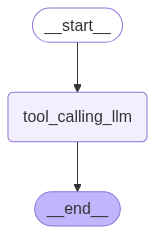

In [50]:
# --- Graph ---

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [51]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


In [52]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_gPlCFJazgprh0Hb7weSnnrne)
 Call ID: call_gPlCFJazgprh0Hb7weSnnrne
  Args:
    a: 2
    b: 3


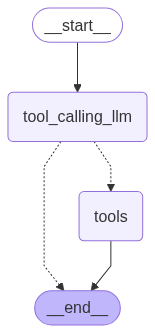

In [53]:
# --- Router ---

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply]))
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
messages = [HumanMessage(content="Quant es 22 per 22?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Quant es 22 per 22?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_J3yRAoom5OCVAprxyWejbsyK)
 Call ID: call_J3yRAoom5OCVAprxyWejbsyK
  Args:
    a: 22
    b: 22
================================= Tool Message =================================
Name: multiply

484


In [58]:
messages = [HumanMessage(content="What are the ingredients of a cheese cake?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What are the ingredients of a cheese cake?
================================== Ai Message ==================================

The ingredients for a basic cheesecake typically include:

1. **Crust**:
   - Graham cracker crumbs (or digestive biscuits)
   - Melted butter
   - Sugar (optional)

2. **Filling**:
   - Cream cheese
   - Granulated sugar
   - Eggs
   - Vanilla extract
   - Sour cream or heavy cream (optional for creaminess)
   - Lemon juice or zest (optional for flavor)

3. **Toppings** (optional):
   - Fresh fruit (like strawberries or blueberries)
   - Fruit preserves or sauces
   - Whipped cream
   - Chocolate or caramel sauce

These ingredients can be adjusted based on the recipe or personal preferences.


In [3]:
# --- Agent ---

# ReAct: Act, Observe, Reason, Finish or ReAct

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatOpenAI(model="gpt-4o-mini")

# For this ipynb we set parallel tool calling to false as math generally is done sequentially, and this time we have 3 tools that can do math
# the OpenAI model specifically defaults to parallel tool calling for efficiency, see https://python.langchain.com/docs/how_to/tool_calling_parallel/
# play around with it and see how the model behaves with math equations!
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

In [4]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

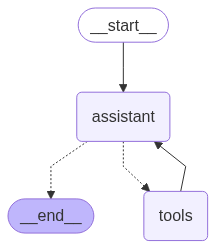

In [5]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [6]:
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 5")]
messages = react_graph.invoke({"messages": messages})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2. Divide the output by 5
================================== Ai Message ==================================
Tool Calls:
  add (call_TdEMs4tEGMLbN8SlSwUrNGHX)
 Call ID: call_TdEMs4tEGMLbN8SlSwUrNGHX
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZB0as1dOHlgEHfb7Tec2TdY9)
 Call ID: call_ZB0as1dOHlgEHfb7Tec2TdY9
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================
Tool Calls:
  divide (call_5YrpEd65OGoUVAAwqhd2F1rF)
 Call ID: call_5YrpEd65OGoUVAAwqhd2F1rF
  Args:
    a: 14
    b: 5
================================= Tool Message ===============

In [8]:
# --- Agent with Memory ---

# Memory

messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()



================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_y7w6KdlinbA7IJw7WcWtKAbw)
 Call ID: call_y7w6KdlinbA7IJw7WcWtKAbw
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Could you please provide the number that you would like to multiply by 2?


In [10]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
react_graph_memory = builder.compile(checkpointer=memory)

In [ ]:
# Specify a thread
config = {"configurable": {"thread_id": "1"}}

# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_xe5gMu7JJzq35oxMthKFeIVu)
 Call ID: call_xe5gMu7JJzq35oxMthKFeIVu
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.


In [12]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_xe5gMu7JJzq35oxMthKFeIVu)
 Call ID: call_xe5gMu7JJzq35oxMthKFeIVu
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The sum of 3 and 4 is 7.
================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_pzZaD8S9dleQYrJHQPzzHn2v)
 Call ID: call_pzZaD8S9dleQYrJHQPzzHn2v
  Args:
    a: 7
    b: 2
================================= Tool Message =================================
Name: multiply

14
================================== Ai Message ==================================

The result of multipl

In [ ]:
# --- LangGraph Ecosystem ---

# LangGraph libraries (Py and JS)
# LangGraph API
# LangGraph Cloud
# LangGraph Studio
# LangGraph SDK